# Simulate quantum dynamics
**Simulating the dynamics of quantum systems in the presence of noise**

The Q-CTRL Python package enables you to simulate the dynamics of quantum systems that are affected by various noise processes. Such simulations can provide useful insights into the expected real-world performance of candidate control solutions. In this notebook we show how to use the Q-CTRL Python package to perform simulations of systems affected by different types of noise.

## Imports and initialization

All usage of the Q-CTRL Python package begins by importing the `qctrl` package and starting a session.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qctrlopencontrols import new_corpse_control, new_primitive_control
from qctrlvisualizer import plot_controls

from qctrl import Qctrl

# Starting a session with the API
qctrl = Qctrl()

## Worked example: Single qubit subject to dephasing noise

In this example we will show how to simulate the dynamics of a single qubit experiencing stochastic dephasing noise, driven by a $\pi/2$ [CORPSE](https://docs.q-ctrl.com/open-controls/references/qctrl-open-controls/qctrlopencontrols/new_corpse_control.html) pulse. The Hamiltonian of the quantum system is:

\begin{align*}
H(t) = & \frac{\Omega(t)}{2} \sigma_- + \frac{\Omega^*(t)}{2} \sigma_+ + \frac{\eta(t)}{2} \sigma_z,
\end{align*}

where $\Omega(t)$ is a time-dependent Rabi rate, $\eta(t)$ is a stochastic dephasing noise process, $\sigma_\pm = (\sigma_x \mp i \sigma_y)/2$, and $\sigma_k$ are the Pauli matrices.

We assume that $\eta(t)$ represents pink noise, as defined below.

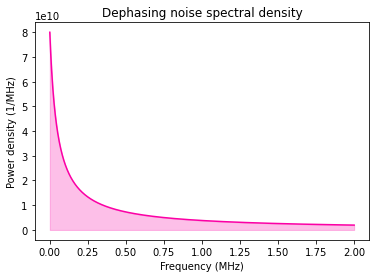

In [2]:
def pink_spectrum(frequencies, frequency_cutoff):
    return 1 / (frequencies + frequency_cutoff)


frequencies = np.linspace(0, 2 * 1e6, 1000)

power_densities = 4e9 * pink_spectrum(
    frequencies=frequencies, frequency_cutoff=0.05 * 1e6
)

plt.plot(frequencies / 1e6, power_densities * 1e6, c="#FB00A5")
plt.fill_between(
    frequencies / 1e6, 0, power_densities * 1e6, alpha=0.25, color="#FB00A5"
)
plt.xlabel("Frequency (MHz)")
plt.ylabel("Power density (1/MHz)")
plt.title("Dephasing noise spectral density")
plt.show()

We now proceed to show how the system, driven by stochastic noise drawn from this power spectral density, may be simulated using the Q-CTRL Python package.

### Creating the pulses

As described in the [Setting up quantum systems](https://docs.q-ctrl.com/boulder-opal/user-guides/setting-up-quantum-systems) user guide, we first set up Python objects representing the pulse, control, and noise.

The [`qctrl.functions.calculate_colored_noise_simulation`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Functions/calculate_colored_noise_simulation.html) function accepts the Hamiltonian in the form of separate terms for each of the complex-valued controls (`drives`), real-valued controls (`shifts`), and static terms (`drifts`).
In the Hamiltonian used in this example, the drive corresponds to the term that contains the Rabi rate ($\Omega(t)$ and $\Omega^*(t)$) and the drift corresponds to the dephasing term (there are no shifts).

The Rabi coupling term is defined using a pulse from Q-CTRL Open Controls.
To create the dephasing noise term, we provide its noise spectral density as a [`qctrl.types.colored_noise_simulation.Noise`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Types/colored_noise_simulation/Noise.html)
by using the frequencies and power densities defined above.

In [3]:
# Define standard matrices
identity = np.array([[1, 0], [0, 1]], dtype=np.complex)
sigma_x = np.array([[0, 1], [1, 0]], dtype=np.complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=np.complex)
sigma_m = np.array([[0, 1], [0, 0]], dtype=np.complex)
square_root_sigma_x = 0.5 * np.array(
    [[1 + 1j, 1 - 1j], [1 - 1j, 1 + 1j]], dtype=np.complex
)

# Define control parameters
omega_max = 2 * np.pi * 1e6  # Hz
total_rotation = np.pi / 2

# Define pulse using pulses from Q-CTRL Open Controls
pulse = new_corpse_control(
    rabi_rotation=total_rotation,
    azimuthal_angle=0.0,
    maximum_rabi_rate=omega_max,
    name="CORPSE",
)

# Define Rabi coupling term
rabi_drive = qctrl.types.colored_noise_simulation.Drive(
    control=[
        qctrl.types.ComplexSegmentInput(duration=d, value=v)
        for d, v in zip(
            pulse.durations, pulse.rabi_rates * np.exp(1j * pulse.azimuthal_angles)
        )
    ],
    operator=sigma_m / 2,
)

# Define dephasing noise term
noise_drift = qctrl.types.colored_noise_simulation.Drift(
    operator=sigma_z,
    noise=qctrl.types.colored_noise_simulation.Noise(
        power_densities=power_densities,
        frequency_step=frequencies[1],
        time_domain_sample_count=100,
    ),
)

### Running the simulation

The computation of a simulation with colored noise is carried out by the [`qctrl.functions.calculate_colored_noise_simulation`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Functions/calculate_colored_noise_simulation.html) function, which takes the following parameters:
* `duration`, the duration of the control pulses,
* `sample_times`, which is a list of sample times at which the dynamics should be calculated,
* `drives`, `shifts`, and `drifts`, which represent the different terms in the Hamiltonian (at least one term needs to be provided),
* `trajectory_count`, which is the number of independent simulations to run using different random realizations of the noise processes,
* `initial_state_vector`, which gives an initial state vector to be propagated according to the calculated dynamics (optional), and
* `target`, which gives the target time evolution operator with respect to which the operational infidelities will be calculated throughout the simulated time period (optional).

In [4]:
# Define sample times for the output
sample_times = np.linspace(0, pulse.duration, 100)

# Define the target (optional)
target = qctrl.types.TargetInput(operator=square_root_sigma_x)

colored_noise_simulation_result = qctrl.functions.calculate_colored_noise_simulation(
    duration=pulse.duration,
    sample_times=sample_times,
    drives=[rabi_drive],
    drifts=[noise_drift],
    trajectory_count=5,
    initial_state_vector=np.array([1.0, 0.0]),
    target=target,
)

  0%|          | 0/100 [00:02<?, ?it/s]

Your task calculate_colored_noise_simulation is currently in a queue waiting to be processed.


100%|██████████| 100/100 [00:03<00:00, 25.93it/s]


### Extracting the average infidelities

After the calculation of all the noisy trajectories, a colored noise simulation returns different types of data.
Here we show how to extract the average infidelity, which gives the operational infidelity of the time evolution operator relative to the specified target, averaged over the ensemble of trajectories.
All average quantities are stored in `colored_noise_simulation_result.average_samples` for each time in the provided `sample_times` (where `colored_noise_simulation_result` is the object returned by `qctrl.functions.calculate_colored_noise_simulation`).

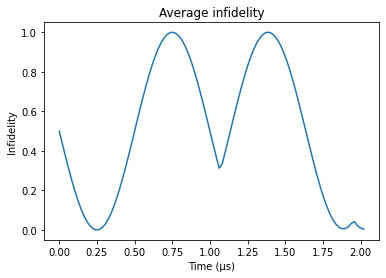

In [5]:
# Extract infidelities
average_infidelities = [
    average_sample.average_infidelity
    for average_sample in colored_noise_simulation_result.average_samples
]

# Plot infidelities
plt.plot(sample_times * 1e6, average_infidelities)
plt.xlabel("Time (µs)")
plt.ylabel("Infidelity")
plt.title("Average infidelity")
plt.show()

### Extracting the average density matrices

`colored_noise_simulation_result.average_samples` also includes the density matrix, the object describing an ensemble of state vectors for the different trajectories.
We can use it (for example) to visualize trajectories of observables.

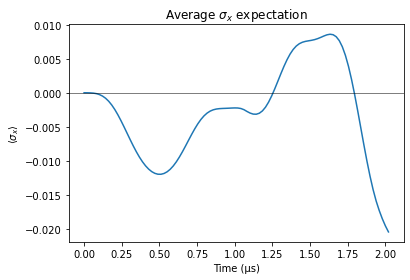

In [6]:
# Extract density matrices
density_matrices = [
    average_sample.average_density_matrix
    for average_sample in colored_noise_simulation_result.average_samples
]

# Calculate and plot average sigma_x expectation
plt.plot(
    sample_times * 1e6,
    [
        np.real(np.trace(sigma_x.dot(density_matrix)))
        for density_matrix in density_matrices
    ],
)
plt.axhline(y=0.0, c="k", lw=0.5)
plt.xlabel("Time (µs)")
plt.ylabel(r"$\langle\sigma_x\rangle$")
plt.title(r"Average $\sigma_x$ expectation")
plt.show()

### Extracting the individual noise trajectories

In addition to the ensemble information available in the average samples, we can extract information about the individual simulation trajectories.
These are stored in `colored_noise_simulation_result.trajectories`.
Here we show how to extract the random realizations of the dephasing noise process.

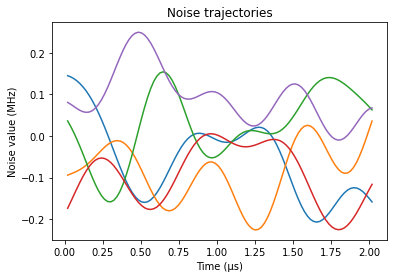

In [7]:
# Extract noise trajectories
noise_points_list = [
    np.array([segment.value for segment in trajectory.noise_realizations[0].segments])
    for trajectory in colored_noise_simulation_result.trajectories
]

# Extract noise sampling times
noise_times = np.cumsum(
    [
        segment.duration
        for segment in colored_noise_simulation_result.trajectories[0]
        .noise_realizations[0]
        .segments
    ]
)

# Plot all noise trajectories
for noise_points in noise_points_list:
    plt.plot(noise_times * 1e6, noise_points / 1e6)

plt.xlabel("Time (µs)")
plt.ylabel("Noise value (MHz)")
plt.title("Noise trajectories")
plt.show()

### Extracting the individual time evolution trajectories

Next we show how to extract from `colored_noise_simulation_result.trajectories` the unitary time evolution operators corresponding to each individual simulation run.

In [8]:
# Extract first two time evolution operator trajectories
evolution_operators_list = [
    [sample.evolution_operator for sample in trajectory.samples]
    for trajectory in colored_noise_simulation_result.trajectories[0:2]
]

# Print initial and final time evolution operators, for both trajectories
print("Time evolution operators at start:")
print(evolution_operators_list[0][0])
print(evolution_operators_list[1][0])
print("\n")
print("Time evolution operators at end:")
print(evolution_operators_list[0][-1])
print(evolution_operators_list[1][-1])

Time evolution operators at start:
[[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]
[[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]


Time evolution operators at end:
[[ 0.70635823-0.07022978j  0.08168007-0.69961003j]
 [-0.08168007-0.69961003j  0.70635823+0.07022978j]]
[[ 0.70451417-0.00899242j -0.06449575-0.70669599j]
 [ 0.06449575-0.70669599j  0.70451417+0.00899242j]]


### Summary

We have shown how to use the Q-CTRL Python package to simulate the dynamics of a system in the presence of a stochastic noise process. We have also shown how to extract several quantities of interest from the simulation result, including both ensemble objects describing the average system behavior and objects associated with specific realizations of the stochastic noise process.

## Example: Single qubit subject to dephasing noise in a large Hilbert space

In this example we simulate the dynamics of a single qubit experiencing stochastic dephasing noise in the presence of two additional, independent, and unaffected qubits.
Since we only care about the average samples here, we can ask to omit the trajectories using the `result_scope` argument.

The Hamiltonian of the quantum system is:

\begin{align*}
H(t) = & \frac{\Omega(t)}{2} \sigma_-^{(1)} + \frac{\Omega^*(t)}{2}\sigma_+^{(1)} + \frac{\eta(t)}{2}\sigma_z^{(1)}
\end{align*}

where $\Omega(t)$ is a time-dependent Rabi rate, $\eta(t)$ is a stochastic dephasing noise process, $\sigma_\pm = (\sigma_x \mp i \sigma_y)/2$, and $\sigma_k$ are the Pauli matrices. We use the superscript to indicate that $\sigma^{(1)}$ is the operator for the first qubit and operators for the other two qubits default to the identity matrix.

We assume that $\eta(t)$ represents pink noise, as defined below.

 76%|███████▌  | 76/100 [00:04<00:00, 25.81it/s]

Your task calculate_colored_noise_simulation has started.


100%|██████████| 100/100 [00:05<00:00, 16.74it/s]


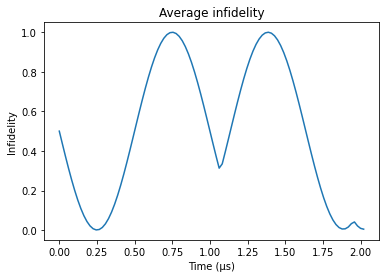

Density matrix at end:
[[ 0.5  +0.j     0.   +0.j     0.   +0.j     0.   +0.j    -0.003+0.498j  0.   +0.j     0.   +0.j     0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j   ]
 [-0.003-0.498j  0.   +0.j     0.   +0.j     0.   +0.j     0.5  +0.j     0.   +0.j     0.   +0.j     0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j   ]]


In [9]:
# Define power spectral density
def pink_spectrum(frequencies, frequency_cutoff):
    return 1 / (frequencies + frequency_cutoff)


frequencies = np.linspace(0, 2 * 1e6, 1000)
power_densities = 4e9 * pink_spectrum(
    frequencies=frequencies, frequency_cutoff=0.05 * 1e6
)

# Define standard matrices
identity = np.array([[1, 0], [0, 1]], dtype=np.complex)
sigma_x = np.array([[0, 1], [1, 0]], dtype=np.complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=np.complex)
sigma_m = np.array([[0, 1], [0, 0]], dtype=np.complex)
square_root_sigma_x = 0.5 * np.array(
    [[1 + 1j, 1 - 1j], [1 - 1j, 1 + 1j]], dtype=np.complex
)


def add_qubits(operator, additional_qubit_count=2):
    large_operator = np.array(operator)
    for _ in range(additional_qubit_count):
        large_operator = np.kron(large_operator, identity)
    return large_operator


# Define control parameters
omega_max = 2 * np.pi * 1e6  # Hz
total_rotation = np.pi / 2

# Define pulse using pulses from Q-CTRL Open Controls
pulse = new_corpse_control(
    rabi_rotation=total_rotation,
    azimuthal_angle=0.0,
    maximum_rabi_rate=omega_max,
    name="CORPSE",
)

# Define Rabi coupling term
rabi_drive = qctrl.types.colored_noise_simulation.Drive(
    control=[
        qctrl.types.ComplexSegmentInput(duration=d, value=v)
        for d, v in zip(
            pulse.durations, pulse.rabi_rates * np.exp(1j * pulse.azimuthal_angles)
        )
    ],
    operator=add_qubits(sigma_m) / 2,
)

# Define dephasing noise term
noise_drift = qctrl.types.colored_noise_simulation.Drift(
    operator=add_qubits(sigma_z),
    noise=qctrl.types.colored_noise_simulation.Noise(
        power_densities=power_densities,
        frequency_step=frequencies[1],
        time_domain_sample_count=100,
    ),
)

# Define sample times for the output
sample_times = np.linspace(0, pulse.duration, 100)

# Define the target (optional)
target = qctrl.types.TargetInput(operator=add_qubits(square_root_sigma_x))

# Run simulation
colored_noise_simulation_result = qctrl.functions.calculate_colored_noise_simulation(
    duration=pulse.duration,
    sample_times=sample_times,
    drives=[rabi_drive],
    drifts=[noise_drift],
    trajectory_count=50,
    initial_state_vector=np.array([1.0] + [0] * (len(rabi_drive.operator) - 1)),
    target=qctrl.types.TargetInput(operator=add_qubits(square_root_sigma_x)),
    result_scope=qctrl.types.colored_noise_simulation.ResultScope.NO_TRAJECTORIES,
)


# Extract infidelities
average_infidelities = [
    average_sample.average_infidelity
    for average_sample in colored_noise_simulation_result.average_samples
]
# Plot infidelities.
plt.plot(sample_times * 1e6, average_infidelities)
plt.xlabel("Time (µs)")
plt.ylabel("Infidelity")
plt.title("Average infidelity")
plt.show()  # This should be the same as the infidelity graph above

print("Density matrix at end:")
with np.printoptions(precision=3, linewidth=120, floatmode="maxprec"):
    print(colored_noise_simulation_result.average_samples[-1].average_density_matrix)

## Example: Single qubit with leakage

In this example we show how to simulate the dynamics of a single qubit subject to leakage to a third energy level (i.e. a qutrit), driven by a primitive $\pi$ pulse. The qutrit is treated as an oscillator (truncated to three levels) with an anharmonicity of $\chi$, described by the Hamiltonian:

\begin{align*}
H(t) = & \frac{\chi}{2} (a^\dagger)^2 a^2 + \frac{\Omega(t)}{2} a + \frac{\Omega^*(t)}{2} a^\dagger,
\end{align*}

where $a = \left|0 \right\rangle \left\langle 1 \right| + \sqrt{2} \left|1 \right\rangle \left\langle 2 \right|$ is the lowering operator and $\Omega(t)$ is a time-dependent Rabi rate.

Below we show how to use the Q-CTRL Python package to simulate the time evolution of this coherent system. We also illustrate how the noise-free infidelity $\mathcal{I}_0$ can be extracted from the coherent simulation results. To do this, we choose as target an X gate between the states $\left| 0 \right\rangle$ and $\left| 1 \right\rangle$. Notice that this target is not unitary in the total Hilbert space, but is still a valid target because it is a partial isometry—in other words, it is unitary in the subspace whose basis is $\{ \left| 0 \right\rangle, \left| 1 \right\rangle \}$.

  0%|          | 0/100 [00:02<?, ?it/s]

Your task calculate_coherent_simulation is currently in a queue waiting to be processed.


100%|██████████| 100/100 [00:03<00:00, 31.10it/s]

Noise-free infidelity at end: 0.08747804107639123
Time evolution operator at end:
[[ 0.05730981-0.14539786j  0.23505273-0.92588994j -0.08764586+0.23531105j]
 [ 0.23505273-0.92588994j -0.06664016+0.18738223j -0.19346042+0.10246022j]
 [-0.08764586+0.23531105j -0.19346042+0.10246022j -0.82544823+0.45569409j]]


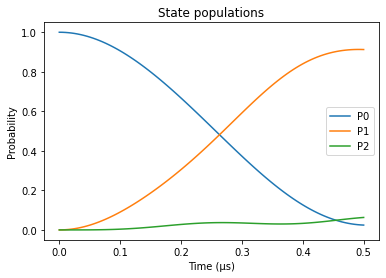

In [10]:
# Define matrices for the Hamiltonian operators
a = np.array(
    [[0.0, 1.0, 0.0], [0.0, 0.0, np.sqrt(2)], [0.0, 0.0, 0.0]], dtype=np.complex
)
ad2a2 = a.T.dot(a.T).dot(a).dot(a)

# Define system parameters
chi = 2 * np.pi * 3 * 1e6  # Hz
omega_max = 2 * np.pi * 1e6  # Hz
total_rotation = np.pi

# Define pulse using pulses from Q-CTRL Open Controls
pulse = new_primitive_control(
    rabi_rotation=total_rotation,
    azimuthal_angle=0.0,
    maximum_rabi_rate=omega_max,
    name="primitive",
)

sample_times = np.linspace(0, pulse.duration, 100)

# Define Rabi coupling term
rabi_drive = qctrl.types.coherent_simulation.Drive(
    control=[
        qctrl.types.ComplexSegmentInput(duration=d, value=v)
        for d, v in zip(
            pulse.durations, pulse.rabi_rates * np.exp(1j * pulse.azimuthal_angles)
        )
    ],
    operator=a / 2,
)

# Define anharmonic term
anharmonic_drift = qctrl.types.coherent_simulation.Drift(
    operator=0.5 * chi * ad2a2,
)

# Define the target
target_operation = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]], dtype=np.complex)
target = qctrl.types.TargetInput(operator=target_operation)

# Run simulation
coherent_simulation_result = qctrl.functions.calculate_coherent_simulation(
    duration=pulse.duration,
    sample_times=sample_times,
    drives=[rabi_drive],
    drifts=[anharmonic_drift],
    initial_state_vector=np.array([1.0, 0.0, 0.0]),
    target=target,
)

# Extract and print final infidelity
print(
    "Noise-free infidelity at end: {}".format(
        coherent_simulation_result.samples[-1].infidelity
    )
)

# Extract and print final time evolution operator
print("Time evolution operator at end:")
print(coherent_simulation_result.samples[-1].evolution_operator)

# Extract and plot state populations
times = np.array([sample.time for sample in coherent_simulation_result.samples])
state_vectors = np.array(
    [sample.state_vector for sample in coherent_simulation_result.samples]
)

for state in range(3):
    plt.plot(
        sample_times * 1e6, np.abs(state_vectors[:, state]) ** 2, label=f"P{state}"
    )
plt.xlabel("Time (µs)")
plt.ylabel("Probability")
plt.title("State populations")
plt.legend()
plt.show()

## Example: Effect of the pulse delay on STIRAP

In this example we show how to simulate the dynamics of a three-level system undergoing stimulated Raman adiabatic passage (STIRAP) when subjected to pump and Stokes pulses.
Below we show how to use the Q-CTRL Python package to create and execute a graph made up of nodes (corresponding to the different steps in the simulation) that represent functions of previous nodes (or of constant values).
Please see the [operations namespace of the Q-CTRL Python package](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Operations.html) for a list of the currently available primitive nodes.

The Hamiltonian of the system is given by
$$
H(t) =
\frac{1}{2} \Omega_{12}(t) \Big(|1\rangle\langle 2| + |2\rangle\langle 1|\Big)
+
\frac{1}{2} \Omega_{23}(t) \Big(|2\rangle\langle 3| + |3\rangle\langle 2|\Big)
,
$$
where the time-dependent Rabi rates for the pump and Stoke pulses are applied for $t\in(0,T)$ with a Gaussian profile:
$$
\Omega_{12}(t) = \Omega_\max \exp\left(- \frac{\left(t - \frac{T}{2} - \frac{t_\textrm{delay}}{2}\right)^2}{2\sigma^2}\right)
\\
\Omega_{23}(t) = \Omega_\max \exp\left(- \frac{\left(t - \frac{T}{2} + \frac{t_\textrm{delay}}{2}\right)^2}{2\sigma^2}\right)
$$
with a maximum amplitude $\Omega_\max$, a pulse width $\sigma$, and a delay between them of $t_\textrm{delay}$.

If the pulses are applied in a counter-intuitive manner, that is, $\Omega_{23}(t)$ is applied before $\Omega_{12}(t)$ (or $t_\textrm{delay} >0$), the STIRAP pulse sequence will transfer the population in state $|1\rangle$ to state $|3\rangle$. In the calculation below, we will see the effect of $t_\textrm{delay}$ on the infidelity of the process. Moreover, we will assume that the input controls are very coarse, consisting of very few segments, but they are passed through a Gaussian filter before acting on the three-level system.

Below we set up and run a graph that creates a batch of input Gaussian pulses (for different values of $t_\textrm{delay}$), filters them, and uses them to simulate the time evolution of the system.
The batch of pulses allows the computations for all values of $t_\textrm{delay}$ to be performed in parallel when the graph is executed.
We then retrieve and plot the infidelities, as well as a pair of the input/filtered pulses simulated.
Notice that the infidelity only goes to 0 when $t_\textrm{delay} > 0$, but if the two pulses are too separated the infidelity increases again.

  0%|          | 0/100 [00:02<?, ?it/s]

Your task calculate_graph is currently in a queue waiting to be processed.


100%|██████████| 100/100 [00:03<00:00, 27.98it/s]


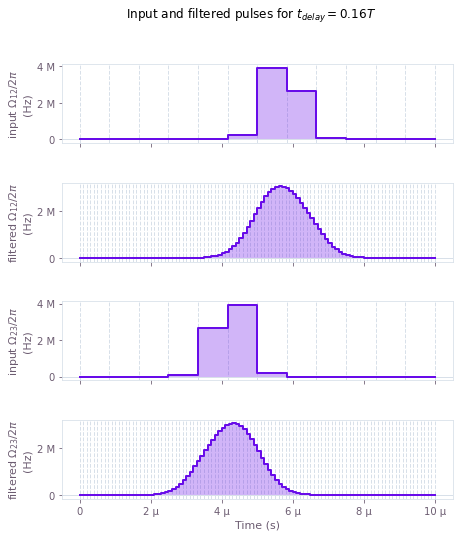

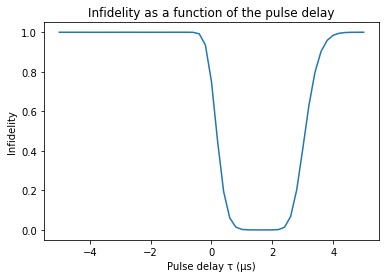

In [11]:
# Define matrices for the Hamiltonian operators
a_12 = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]])
a_23 = np.array([[0, 0, 0], [0, 0, 1], [0, 1, 0]])

# Define the target unitary: state |1> goes to state |3>
target_operation = np.array([[0, 0, 0], [0, 0, 0], [1, 0, 0]])

# Define system parameters
omega_max = 2 * np.pi * 5e6  # Hz
total_duration = 10.0e-6  # s
sigma = 0.5e-6
gauss_filter_std = 0.5e-6
input_segment_count = 12
filtered_segment_count = 100

times = np.linspace(0.0, total_duration, input_segment_count)
durations = np.array([total_duration / input_segment_count] * input_segment_count)

# Define values of t_delay
t_delay_values = np.linspace(-total_duration / 2, total_duration / 2, 51)

# Create batch of coarse input pulses
omega_12_pulse = omega_max * np.exp(
    -0.5
    * (times[None] - total_duration / 2.0 - t_delay_values[:, None] / 2.0) ** 2
    / sigma ** 2
)
omega_23_pulse = omega_max * np.exp(
    -0.5
    * (times[None] - total_duration / 2.0 + t_delay_values[:, None] / 2.0) ** 2
    / sigma ** 2
)

# Define the data flow graph describing the system
with qctrl.create_graph() as graph:

    # Create input signals
    omega_12_signal = qctrl.operations.pwc_signal(
        values=omega_12_pulse, duration=total_duration, name="omega_12_signal"
    )
    omega_23_signal = qctrl.operations.pwc_signal(
        values=omega_23_pulse, duration=total_duration, name="omega_23_signal"
    )

    # Filter signals through a Gaussian filter
    filtered_omega_12_signal = qctrl.operations.convolve_pwc(
        omega_12_signal,
        qctrl.operations.gaussian_integral_function(gauss_filter_std, offset=0),
    )
    filtered_omega_23_signal = qctrl.operations.convolve_pwc(
        omega_23_signal,
        qctrl.operations.gaussian_integral_function(gauss_filter_std, offset=0),
    )

    # Discretize filtered signals to output smoothed signals
    sampled_filtered_pulse_12 = qctrl.operations.discretize_stf(
        stf=filtered_omega_12_signal,
        duration=total_duration,
        segments_count=filtered_segment_count,
        name="filtered_omega_12_signal",
    )
    sampled_filtered_pulse_23 = qctrl.operations.discretize_stf(
        stf=filtered_omega_23_signal,
        duration=total_duration,
        segments_count=filtered_segment_count,
        name="filtered_omega_23_signal",
    )

    # Create Hamiltonian terms
    omega_12_term = qctrl.operations.stf_operator(
        signal=filtered_omega_12_signal, operator=a_12
    )
    omega_23_term = qctrl.operations.stf_operator(
        signal=filtered_omega_23_signal, operator=a_23
    )

    # Define the target operation
    target = qctrl.operations.target(operator=target_operation)

    # Calculate the infidelities
    qctrl.operations.infidelity_stf(
        sample_times=np.linspace(0, total_duration, filtered_segment_count),
        hamiltonian=qctrl.operations.stf_sum([omega_12_term, omega_23_term]),
        target_operator=target,
        name="infidelities",
    )

# Run simulation
graph_result = qctrl.functions.calculate_graph(
    graph=graph,
    output_node_names=[
        "infidelities",
        "omega_12_signal",
        "omega_23_signal",
        "filtered_omega_12_signal",
        "filtered_omega_23_signal",
    ],
)

# Plot the input/filtered pulses
fig = plt.figure()
plot_controls(
    fig,
    {
        "input $\Omega_{12}$": graph_result.output["omega_12_signal"][33],
        "filtered $\Omega_{12}$": graph_result.output["filtered_omega_12_signal"][33],
        "input $\Omega_{23}$": graph_result.output["omega_23_signal"][33],
        "filtered $\Omega_{23}$": graph_result.output["filtered_omega_23_signal"][33],
    },
)
fig.suptitle("Input and filtered pulses for $t_{delay} = 0.16 T$")

# Plot the infidelities obtained as a function of the pulse delay
plt.figure()
plt.plot(t_delay_values / 1e-6, graph_result.output["infidelities"]["value"])
plt.xlabel("Pulse delay τ (µs)")
plt.ylabel("Infidelity")
plt.title("Infidelity as a function of the pulse delay")
plt.show()

## Example: Generating entangled states in atomic chains

In this example we show how to simulate the adiabatic dynamics of a multi-atomic system going from the ground state to an entangled state involving all atoms.
We again create and execute a graph made up of the nodes in the [operations namespace of the Q-CTRL Python package](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Operations.html) in order to simulate the dynamics of an atomic chain.

We consider a chain of $N=8$ atoms, each one modeled as a qubit, with $|0\rangle$ representing the ground state and $|1\rangle$ representing a Rydberg state.
The total Hamiltonian of the system, as described by [A. Omran et al.](https://science.sciencemag.org/content/365/6453/570), is given by

$$ H = \frac{\Omega(t)}{2} \sum_{i=1}^N \sigma_x^{(i)} - \Delta(t) \sum_{i=1}^N n_i - \sum_{i=1}^N \delta_i n_i + \sum_{i<j}^N \frac{V}{\vert i-j \vert^6}n_i n_j , $$

with $\sigma_x^{(i)} = \vert 0 \rangle \langle 1 \vert_i + \vert 1 \rangle \langle 0 \vert_i$, and $n_i = \vert 1\rangle\langle 1 \vert_i$.
The fixed system parameters are the interaction strength between excited atoms, $V= 2\pi \times 24$ MHz, and the local energy shifts $\delta_i =  - 2 \pi \times 4.5$ MHz for $i=1,N$ or 0 otherise.

We consider the system to be initially in its ground state,
$ |\psi(t=0)\rangle = |00000000\rangle$ ,
and we aim to prepare the entangled target state
$|\psi_\mathrm{target}\rangle = \frac{1}{\sqrt{2}} \Big( |01010101\rangle + |10101010\rangle \Big) $.
To achieve this superposition, the effective coupling strength to the Rydberg state $\Omega(t)$ is pulsed while the detuning $\Delta(t)$ is swept around zero, for a total time of $T = 1.1$ µs.

  0%|          | 0/100 [00:04<?, ?it/s]

Your task calculate_graph has started.


100%|██████████| 100/100 [00:18<00:00,  5.31it/s]


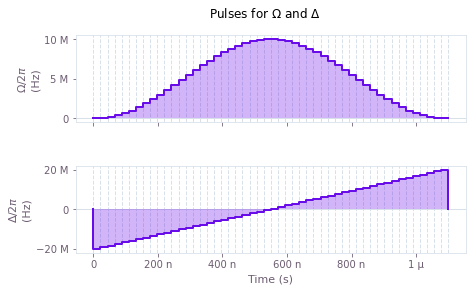

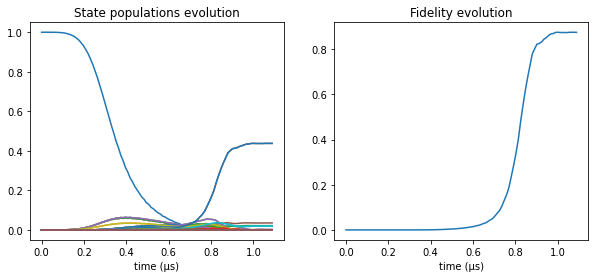

In [12]:
# Physical parameters of the systems
N_qubits = 8
interaction_strength = 24.0e6 * (2.0 * np.pi)  # Hz
local_shift = -4.5e6 * (2.0 * np.pi)  # Hz
omega_max = 10.0e6 * (2.0 * np.pi)  # Hz
delta_max = 20.0e6 * (2.0 * np.pi)  # Hz
total_duration = 1.1e-6
segments = 50
sample_times = np.linspace(0.0, total_duration, 100, endpoint=False)

# Single qubit operators
sigma_x = np.array([[0, 1], [1, 0]])
n_operator = np.array([[0, 0], [0, 1]])

# Function that returns the operator for the k-th qubit in a chain of N atoms
def operator_k(operator, k, N):
    A = np.kron(np.identity(2 ** (k)), operator)
    A = np.kron(A, np.identity(2 ** (N - k - 1)))
    return A


# Coupling strength to the Rydberg state operator
sigma_x_sum = sum([operator_k(sigma_x, k, N_qubits) for k in range(N_qubits)])

# Detuning operator
n_operator_list = np.array(
    [operator_k(n_operator, k, N_qubits) for k in range(N_qubits)]
)
n_operator_sum = np.sum(n_operator_list, 0)

# Local energy shift operator
local_shifts = np.zeros(N_qubits)
local_shifts[0] = local_shift
local_shifts[-1] = local_shift
local_shift_operator = np.sum(local_shifts[:, None, None] * n_operator_list, 0)

# Interaction operator
interaction_operator = 0
for idx1, n_op1 in enumerate(n_operator_list):
    for idx2, n_op2 in enumerate(n_operator_list[:idx1]):
        interaction_operator += np.dot(n_op1, n_op2) / np.abs(idx1 - idx2) ** 6
interaction_operator *= interaction_strength

# Initial state
initial_state = np.zeros([2 ** N_qubits])
initial_state[0] = 1.0

# Target GHZ state
idx_even = sum([2 ** n for n in range(0, N_qubits, 2)])  # |0101...>
idx_odd = sum([2 ** n for n in range(1, N_qubits, 2)])  # |1010...>
GHZ_state = np.zeros([2 ** N_qubits])
GHZ_state[[idx_even, idx_odd]] = 1.0 / np.sqrt(2.0)


# Define the data flow graph describing the system
with qctrl.create_graph() as graph:

    # Signals for delta and omega
    omega_signal = qctrl.operations.pwc_signal(
        values=omega_max * np.sin(np.pi * np.linspace(0, 1, segments)) ** 2.0,
        duration=total_duration,
        name="omega",
    )
    delta_signal = qctrl.operations.pwc_signal(
        values=delta_max * np.linspace(-1, 1, segments),
        duration=total_duration,
        name="delta",
    )

    # Construct the Hamiltonian
    omega_term = qctrl.operations.pwc_operator(
        signal=omega_signal, operator=0.5 * sigma_x_sum
    )
    delta_term = qctrl.operations.pwc_operator(
        signal=delta_signal, operator=-n_operator_sum
    )
    constant_term = qctrl.operations.constant_pwc_operator(
        duration=total_duration, operator=interaction_operator - local_shift_operator
    )
    hamiltonian = qctrl.operations.pwc_sum([omega_term, delta_term, constant_term])

    # Calculate the evolution unitaries and evolve the initial state
    unitaries = qctrl.operations.time_evolution_operators_pwc(
        hamiltonian=hamiltonian, sample_times=sample_times
    )
    evolved_states = unitaries @ initial_state[:, None]
    evolved_states.name = "evolved_states"

    # Project the evolved and target states to calculate the fidelity
    fidelity = qctrl.operations.abs(GHZ_state[None] @ evolved_states) ** 2
    fidelity.name = "fidelity"


# Run simulation
graph_result = qctrl.functions.calculate_graph(
    graph=graph, output_node_names=["omega", "delta", "evolved_states", "fidelity"]
)


# Plot the controls
fig = plt.figure()
plot_controls(
    fig,
    {
        "$\Omega$": graph_result.output["omega"],
        "$\Delta$": graph_result.output["delta"],
    },
)
fig.suptitle("Pulses for $\Omega$ and $\Delta$")

# Retrieve and plot the evolved states and fidelity
evolved_states = graph_result.output["evolved_states"]["value"].squeeze()
fidelity = graph_result.output["fidelity"]["value"].squeeze()

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(sample_times * 1e6, np.abs(evolved_states) ** 2)
axs[1].plot(sample_times * 1e6, fidelity)
axs[0].set_xlabel("time (µs)")
axs[0].set_title("State populations evolution")
axs[1].set_xlabel("time (µs)")
axs[1].set_title("Fidelity evolution")
plt.show()